In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
# from keras.callbacks import EarlyStopping
# import keras

from sklearn.ensemble import RandomForestClassifier
from matplotlib.legend_handler import HandlerLine2D

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
cwd = os.getcwd() 
print(cwd)

/content


In [ ]:
df_list = []
for filename in glob.glob("/content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/*"):
  print("Processing " + filename)
  df = pd.read_pickle(filename)
  df_list.append(df)

all_data = pd.concat(df_list, axis=0)
all_data.count()

Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/1000-2000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/2000-3000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/3000-4000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/4000-5000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/5000-6000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/6000-7000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/0001-1000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/7000-8000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/8000-9000_mfcc_EDA_data
Processing /content/drive/My

filename              73465
text                  73465
up_votes              73465
down_votes            73465
age                   73465
gender                73465
accent                63163
mean_RMSE             73465
mean_spec_centroid    73465
mfcc                  73465
meanff                72999
q1                    73465
iqr                   73465
chroma                73465
mel                   73465
dtype: int64

In [ ]:
sound_data = all_data.copy()

In [ ]:
sound_data = sound_data.drop(columns=['up_votes','down_votes','text','accent'])
sound_data.head()

,filename,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
1000,cv-valid-train/sample-002750.mp3,thirties,male,0.025066,2333.515420,"[[-653.66547, -553.5895, -507.24734, -510.7036...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1001,cv-valid-train/sample-002756.mp3,fifties,female,0.086192,1875.045261,"[[-351.88895, -266.37778, -290.86395, -292.594...",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
1002,cv-valid-train/sample-002762.mp3,thirties,female,0.002153,3797.429451,"[[-854.9337, -840.2629, -825.6537, -820.5658, ...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
1003,cv-valid-train/sample-002763.mp3,seventies,male,0.009721,2595.827243,"[[-630.77386, -536.9595, -541.82056, -642.6946...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
1004,cv-valid-train/sample-002765.mp3,fourties,male,0.013881,2043.898864,"[[-736.3709, -693.187, -660.3091, -656.9877, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
sound_data.reset_index(drop=True, inplace=True)   

In [ ]:
sound_data.drop(sound_data[sound_data["gender"]=="other"].index, inplace=True)

In [ ]:
sound_data.drop(columns=["filename"], inplace=True)

In [ ]:
age_dict = {
    "teens": 0,
    "twenties": 1,
    "thirties": 2,
    "fourties": 3,
    "fifties": 4,
    "sixties": 5,
    "seventies": 6,
    "eighties": 7
}
gender_dict = {
    "male": 0,
    "female": 1
}

for i in range(sound_data.shape[0]):
  sound_data["age"].iloc[i] = age_dict[sound_data["age"].iloc[i]]
  sound_data["gender"].iloc[i] = gender_dict[sound_data["gender"].iloc[i]]

sound_data.head(5)

,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[[-653.66547, -553.5895, -507.24734, -510.7036...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[[-351.88895, -266.37778, -290.86395, -292.594...",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[[-854.9337, -840.2629, -825.6537, -820.5658, ...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[[-630.77386, -536.9595, -541.82056, -642.6946...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[[-736.3709, -693.187, -660.3091, -656.9877, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


### Gender

In [ ]:
def get_np_means(arr):
  return np.mean(arr.T, axis=0)

In [ ]:
gender_data = sound_data.copy()


# np.mean() mfccs
gender_data["mfcc"] = gender_data["mfcc"].apply(get_np_means)
gender_data = gender_data.dropna()
gender_data.head()

,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[-393.8289, 85.47335, 1.4228904, 24.578445, -1...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[-363.5393, 78.68751, -9.93091, 9.993607, -15....",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[-708.3258, 44.437115, 37.39505, 11.696047, -2...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[-529.4351, 81.02429, 5.8359385, 28.622475, -8...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[-516.62335, 108.33303, 18.175974, 20.33933, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
y = gender_data['gender']

In [ ]:
single_data_columns = ["mean_RMSE","mean_spec_centroid","meanff","q1","iqr"]

combined = gender_data[single_data_columns].values
# print(combined)


xs_raw = []

for i in range(gender_data.shape[0]):
  mfcc = gender_data["mfcc"].iloc[i]
  chroma = gender_data["chroma"].iloc[i]
  mel = gender_data["mel"].iloc[i]
  combined_stats = combined[i]

  xs_raw.append(np.concatenate((
      combined_stats,
      mfcc,
      chroma,
      mel), axis=0))
  
xs_raw = np.array(xs_raw)
print(xs_raw)
print(xs_raw.shape)
x = pd.DataFrame.from_records(xs_raw)

[[2.50655767e-02 2.33351542e+03 1.78808002e+02 ... 4.22360936e-05
  1.92060543e-05 1.31902630e-06]
 [8.61921087e-02 1.87504526e+03 3.81535309e+02 ... 1.62144227e-06
  7.14589817e-07 5.00375350e-08]
 [2.15272792e-03 3.79742945e+03 2.39809806e+02 ... 5.28863939e-06
  9.51967593e-07 1.53635611e-08]
 ...
 [3.49693485e-02 2.09002172e+03 1.31681293e+02 ... 3.39935534e-04
  9.07320500e-05 7.50682648e-06]
 [2.74989884e-02 2.47999615e+03 2.17378584e+02 ... 4.85678262e-04
  9.98327887e-05 4.51164624e-06]
 [6.60601584e-03 2.15442749e+03 1.24400531e+02 ... 7.34049252e-07
  2.26723259e-07 1.48708184e-08]]
(72228, 165)


In [ ]:
y=y.astype('int')

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state = 0)
os_x, os_y = oversampler.fit_sample(x, y)
x_train, x_test, y_train, y_test = train_test_split(os_x, os_y, test_size = 0.2, random_state = 0)

In [ ]:
ss = StandardScaler()
mm = MinMaxScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(objective = "binary:logistic", random_state = 0)
xgb_model.fit(x_train, y_train)

y_train_pred = xgb_model.predict(x_train)
y_test_pred = xgb_model.predict(x_test)

target_names = ['class 0 - male', 'class 1 - female']
classification_report_train = classification_report(y_train, y_train_pred, target_names=target_names)
accuracy_train = accuracy_score(y_train_pred, y_train)

classification_report_test = classification_report(y_test, y_test_pred, target_names=target_names)
accuracy_test = accuracy_score(y_test_pred, y_test)


In [ ]:
def xgboost_model(max_depth=6,n_estimators=10,min_child_weight=0.5,colsample_bytree=0.5,
                  subsample=0.5,learning_rate=0.1):
  
    xgb_model = XGBClassifier(objective = "binary:logistic", max_depth = max_depth,
                              n_estimators=n_estimators, min_child_weight=min_child_weight,
                              colsample_bytree=colsample_bytree, subsample=subsample,learning_rate =learning_rate, 
                              random_state = 0)
    xgb_model.fit(x_train, y_train)

    y_train_pred = xgb_model.predict(x_train)
    y_test_pred = xgb_model.predict(x_test)

    return y_train_pred, y_test_pred


def print_report(y_train_pred, y_test_pred, target_names = ['class 0 - male', 'class 1 - female']):

  classification_report_train = classification_report(y_train, y_train_pred, target_names=target_names)
  accuracy_train = accuracy_score(y_train_pred, y_train)

  classification_report_test = classification_report(y_test, y_test_pred, target_names=target_names)
  accuracy_test = accuracy_score(y_test_pred, y_test)

  print("-" * 50)
  print("TRAIN")
  print("-" * 50)
  print("classification report: ")
  print(classification_report_train)
  print("accuracy score: " + str(accuracy_train))
  print("-" * 50)
  print("TEST")
  print("-" * 50)
  print("classification report: ") 
  print(classification_report_test)
  print("accuracy score: " + str(accuracy_test))

Default XGBoost Model

In [ ]:
 y_train_pred, y_test_pred = xgboost_model()
 print_report(y_train_pred, y_test_pred)

--------------------------------------------------
TRAIN
--------------------------------------------------
classification report: 
                  precision    recall  f1-score   support

  class 0 - male       0.94      0.94      0.94     43396
class 1 - female       0.94      0.94      0.94     43240

        accuracy                           0.94     86636
       macro avg       0.94      0.94      0.94     86636
    weighted avg       0.94      0.94      0.94     86636

accuracy score: 0.9402904104529295
--------------------------------------------------
TEST
--------------------------------------------------
classification report: 
                  precision    recall  f1-score   support

  class 0 - male       0.95      0.71      0.81     10752
class 1 - female       0.77      0.97      0.86     10908

        accuracy                           0.84     21660
       macro avg       0.86      0.84      0.84     21660
    weighted avg       0.86      0.84      0.84     21660



Best n estimators

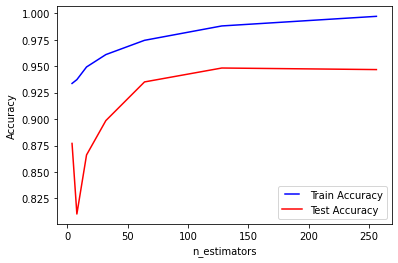

In [ ]:
train_results = []
test_results = []
n_estimators = [4, 8, 16, 32, 64, 128, 256]
best_estimator, acc = 0,0

for estimator in n_estimators:
    y_train_pred, y_test_pred = xgboost_model(n_estimators=estimator)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
      best_estimator, acc = estimator, accuracy_test


line1, = plt.plot(n_estimators, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(n_estimators, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()

Different Max Depth

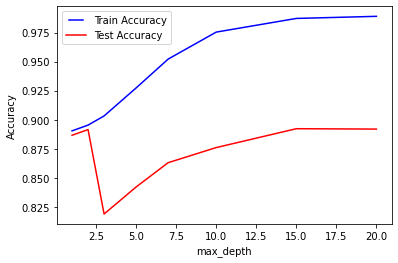

In [ ]:
train_results = []
test_results = []
max_depth = [1, 2, 3, 5, 7, 10, 15, 20]
best_depth, acc = 0,0

for depth in max_depth:
    y_train_pred, y_test_pred = xgboost_model(max_depth = depth)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_depth, acc = depth, accuracy_test


line1, = plt.plot(max_depth, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(max_depth, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('max_depth')
plt.show()

Different min_child_weight

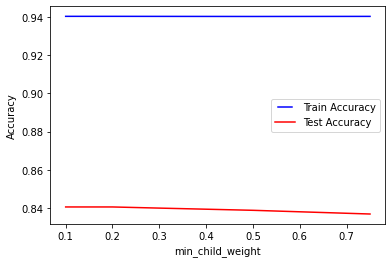

In [ ]:
train_results = []
test_results = []
min_child_weight = [0.1, 0.2, 0.3, 0.5, 0.75]
best_min_child_weight, acc = 0,0

for child in min_child_weight:
    y_train_pred, y_test_pred = xgboost_model(min_child_weight=child)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_min_child_weight, acc = child, accuracy_test


line1, = plt.plot(min_child_weight, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(min_child_weight, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('min_child_weight')
plt.show()

Different colsample_bytree

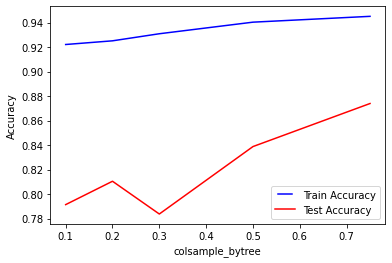

In [ ]:
train_results = []
test_results = []
colsample_bytree = [0.1, 0.2, 0.3, 0.5, 0.75]
best_colsample_bytree, acc = 0,0

for colsample in colsample_bytree:
    y_train_pred, y_test_pred = xgboost_model(colsample_bytree=colsample)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_colsample_bytree, acc = colsample, accuracy_test


line1, = plt.plot(colsample_bytree, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(colsample_bytree, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('colsample_bytree')
plt.show()

Different subsample

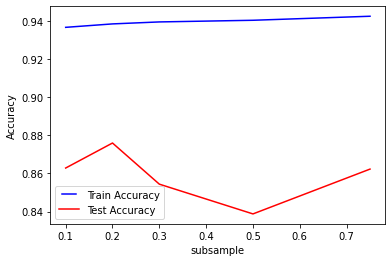

In [ ]:
train_results = []
test_results = []
subsample = [0.1, 0.2, 0.3, 0.5, 0.75]
best_subsample, acc = 0,0

for each in subsample:
    y_train_pred, y_test_pred = xgboost_model(subsample=each)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_subsample, acc = each, accuracy_test


line1, = plt.plot(subsample, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(subsample, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('subsample')
plt.show()

Different learning_rate

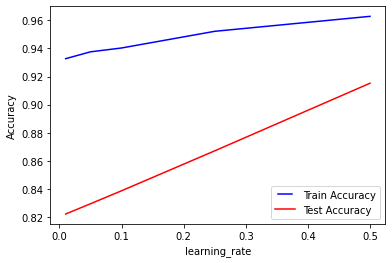

In [ ]:
train_results = []
test_results = []
learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
best_learning_rate, acc = 0,0

for learn_rate in learning_rate:
    y_train_pred, y_test_pred = xgboost_model(learning_rate=learn_rate)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_learning_rate, acc = learn_rate, accuracy_test


line1, = plt.plot(learning_rate, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(learning_rate, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('learning_rate')
plt.show()

BEST Model

In [ ]:
 y_train_pred, y_test_pred = xgboost_model(max_depth=best_depth,n_estimators=best_estimator,
                                           min_child_weight=best_min_child_weight,colsample_bytree=best_colsample_bytree,
                                           subsample=best_subsample,learning_rate=best_learning_rate)
 print_report(y_train_pred, y_test_pred)

--------------------------------------------------
TRAIN
--------------------------------------------------
classification report: 
                  precision    recall  f1-score   support

  class 0 - male       1.00      1.00      1.00     43396
class 1 - female       1.00      1.00      1.00     43240

        accuracy                           1.00     86636
       macro avg       1.00      1.00      1.00     86636
    weighted avg       1.00      1.00      1.00     86636

accuracy score: 0.9999884574541761
--------------------------------------------------
TEST
--------------------------------------------------
classification report: 
                  precision    recall  f1-score   support

  class 0 - male       0.98      0.87      0.93     10752
class 1 - female       0.89      0.99      0.93     10908

        accuracy                           0.93     21660
       macro avg       0.94      0.93      0.93     21660
    weighted avg       0.94      0.93      0.93     21660



In [ ]:
print(f'best_depth is {best_depth}')
print(f'best_estimator is {best_estimator}')
print(f'best_min_child_weight is {best_min_child_weight}')
print(f'best_colsample_bytree is {best_colsample_bytree}')
print(f'best_subsample is {best_subsample}')
print(f'best_learning_rate is {best_learning_rate}')

best_depth is 15
best_estimator is 128
best_min_child_weight is 0.1
best_colsample_bytree is 0.75
best_subsample is 0.2
best_learning_rate is 0.5


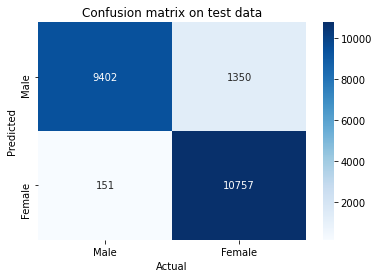

In [ ]:
#plot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test,y_test_pred) , index = ['Male', 'Female'] , columns = ['Male', 'Female'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Male', 'Female'], yticklabels = ['Male', 'Female'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()

# AGE

In [ ]:
def get_np_means(arr):
  return np.mean(arr.T, axis=0)

In [ ]:
age_data = sound_data.copy()

# np.mean() mfccs
age_data["mfcc"] = age_data["mfcc"].apply(get_np_means)
age_data = age_data.dropna()
age_data.head()

,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[-393.8289, 85.47335, 1.4228904, 24.578445, -1...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[-363.5393, 78.68751, -9.93091, 9.993607, -15....",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[-708.3258, 44.437115, 37.39505, 11.696047, -2...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[-529.4351, 81.02429, 5.8359385, 28.622475, -8...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[-516.62335, 108.33303, 18.175974, 20.33933, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
age_data['age'].value_counts()
age_data.drop(age_data[age_data.age == 6].index, inplace=True)
age_data.drop(age_data[age_data.age == 7].index, inplace=True)

In [ ]:
y = age_data['age']
y=y.astype('int')

In [ ]:
age_data = age_data.drop(columns=["age"])
age_data.head(5)

,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,0,0.025066,2333.515420,"[-393.8289, 85.47335, 1.4228904, 24.578445, -1...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,1,0.086192,1875.045261,"[-363.5393, 78.68751, -9.93091, 9.993607, -15....",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,1,0.002153,3797.429451,"[-708.3258, 44.437115, 37.39505, 11.696047, -2...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
4,0,0.013881,2043.898864,"[-516.62335, 108.33303, 18.175974, 20.33933, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."
5,0,0.004608,2997.658693,"[-575.6909, 79.226776, -17.957748, 20.28985, -...",107.374478,0.446778,0.834392,"[0.73932433, 0.733532, 0.73316735, 0.722793, 0...","[3.4892713e-05, 4.3915235e-05, 0.00050203706, ..."


In [ ]:
single_data_columns = ["mean_RMSE","mean_spec_centroid","meanff","q1","iqr"]

combined = gender_data[single_data_columns].values

# print(combined)


xs_raw = []

for i in range(age_data.shape[0]):
  mfcc = age_data["mfcc"].iloc[i]
  chroma = age_data["chroma"].iloc[i]
  mel = age_data["mel"].iloc[i]
  combined_stats = combined[i]

  xs_raw.append(np.concatenate((
      combined_stats,
      mfcc,
      chroma,
      mel), axis=0))
  
xs_raw = np.array(xs_raw)
print(xs_raw)
print(xs_raw.shape)
x = pd.DataFrame.from_records(xs_raw)

[[2.50655767e-02 2.33351542e+03 1.78808002e+02 ... 4.22360936e-05
  1.92060543e-05 1.31902630e-06]
 [8.61921087e-02 1.87504526e+03 3.81535309e+02 ... 1.62144227e-06
  7.14589817e-07 5.00375350e-08]
 [2.15272792e-03 3.79742945e+03 2.39809806e+02 ... 5.28863939e-06
  9.51967593e-07 1.53635611e-08]
 ...
 [1.08028222e-02 2.22676237e+03 1.21748693e+02 ... 3.39935534e-04
  9.07320500e-05 7.50682648e-06]
 [5.39751537e-02 2.69387736e+03 1.66434881e+02 ... 4.85678262e-04
  9.98327887e-05 4.51164624e-06]
 [9.74893291e-03 1.91390603e+03 1.02356288e+02 ... 7.34049252e-07
  2.26723259e-07 1.48708184e-08]]
(70388, 165)


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state = 0)
os_x, os_y = oversampler.fit_sample(x, y)
# os_x,os_y = np.load("os_x_age.npy"), np.load("os_y_age.npy")
x_train, x_test, y_train, y_test = train_test_split(os_x, os_y, test_size = 0.2, random_state = 0)

In [ ]:
ss = StandardScaler()
mm = MinMaxScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

In [ ]:
def xgboost_model(max_depth=6,n_estimators=10,min_child_weight=0.5,colsample_bytree=0.5,
                  subsample=0.5,learning_rate=0.1):
  
    xgb_model = XGBClassifier(objective = "multi:softmax", max_depth = max_depth,
                              n_estimators=n_estimators, min_child_weight=min_child_weight,
                              colsample_bytree=colsample_bytree, subsample=subsample,learning_rate =learning_rate, 
                              random_state = 0)
    xgb_model.fit(x_train, y_train)

    y_train_pred = xgb_model.predict(x_train)
    y_test_pred = xgb_model.predict(x_test)

    return y_train_pred, y_test_pred


def print_report(y_train_pred, y_test_pred):

  classification_report_train = classification_report(y_train, y_train_pred)
  accuracy_train = accuracy_score(y_train_pred, y_train)

  classification_report_test = classification_report(y_test, y_test_pred)
  accuracy_test = accuracy_score(y_test_pred, y_test)

  print("-" * 50)
  print("TRAIN")
  print("-" * 50)
  print("classification report: ")
  print(classification_report_train)
  print("accuracy score: " + str(accuracy_train))
  print("-" * 50)
  print("TEST")
  print("-" * 50)
  print("classification report: ") 
  print(classification_report_test)
  print("accuracy score: " + str(accuracy_test))

Default Model

In [ ]:
 y_train_pred, y_test_pred = xgboost_model()
 print_report(y_train_pred, y_test_pred)

--------------------------------------------------
TRAIN
--------------------------------------------------
classification report: 
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     17949
           1       0.44      0.52      0.48     17925
           2       0.55      0.36      0.44     17777
           3       0.53      0.58      0.55     17844
           4       0.66      0.52      0.58     17887
           5       0.63      0.81      0.71     17806

    accuracy                           0.57    107188
   macro avg       0.58      0.57      0.57    107188
weighted avg       0.58      0.57      0.57    107188

accuracy score: 0.5742620442586857
--------------------------------------------------
TEST
--------------------------------------------------
classification report: 
              precision    recall  f1-score   support

           0       0.64      0.29      0.40      4382
           1       0.35      0.33      0.34      4

Best n estimators

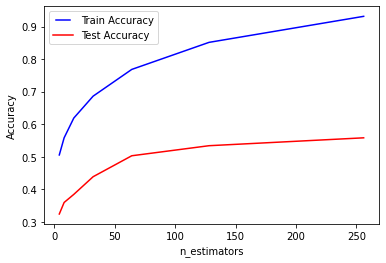

In [ ]:
train_results = []
test_results = []
n_estimators = [4, 8, 16, 32, 64, 128, 256]
best_estimator, acc = 0,0

for estimator in n_estimators:
    y_train_pred, y_test_pred = xgboost_model(n_estimators=estimator)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
      best_estimator, acc = estimator, accuracy_test


line1, = plt.plot(n_estimators, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(n_estimators, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()

Different Max Depth

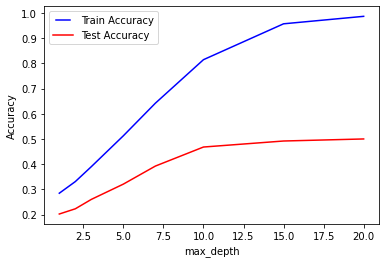

In [ ]:
train_results = []
test_results = []
max_depth = [1, 2, 3, 5, 7, 10, 15, 20]
best_depth, acc = 0,0

for depth in max_depth:
    y_train_pred, y_test_pred = xgboost_model(max_depth = depth)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_depth, acc = depth, accuracy_test


line1, = plt.plot(max_depth, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(max_depth, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('max_depth')
plt.show()

Different min_child_weight

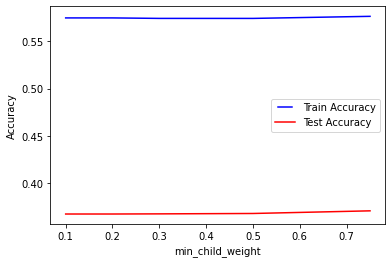

In [ ]:
train_results = []
test_results = []
min_child_weight = [0.1, 0.2, 0.3, 0.5, 0.75]
best_min_child_weight, acc = 0,0

for child in min_child_weight:
    y_train_pred, y_test_pred = xgboost_model(min_child_weight=child)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_min_child_weight, acc = child, accuracy_test


line1, = plt.plot(min_child_weight, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(min_child_weight, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('min_child_weight')
plt.show()

Different colsample_bytree

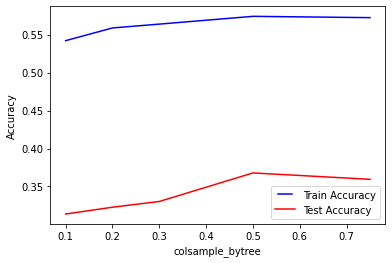

In [ ]:
train_results = []
test_results = []
colsample_bytree = [0.1, 0.2, 0.3, 0.5, 0.75]
best_colsample_bytree, acc = 0,0

for colsample in colsample_bytree:
    y_train_pred, y_test_pred = xgboost_model(colsample_bytree=colsample)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_colsample_bytree, acc = colsample, accuracy_test


line1, = plt.plot(colsample_bytree, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(colsample_bytree, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('colsample_bytree')
plt.show()

Different subsample

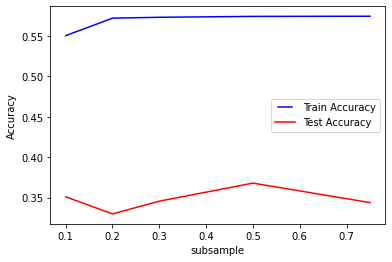

In [ ]:
train_results = []
test_results = []
subsample = [0.1, 0.2, 0.3, 0.5, 0.75]
best_subsample, acc = 0,0

for each in subsample:
    y_train_pred, y_test_pred = xgboost_model(subsample=each)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_subsample, acc = each, accuracy_test


line1, = plt.plot(subsample, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(subsample, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('subsample')
plt.show()

Different learning_rate

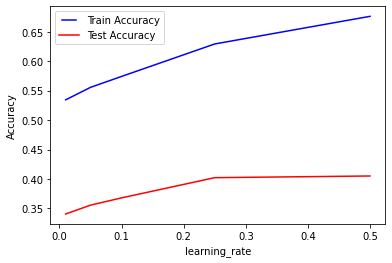

In [ ]:
train_results = []
test_results = []
learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
best_learning_rate, acc = 0,0

for learn_rate in learning_rate:
    y_train_pred, y_test_pred = xgboost_model(learning_rate=learn_rate)

    accuracy_train = accuracy_score(y_train_pred, y_train)
    train_results.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_pred, y_test)
    test_results.append(accuracy_test)

    if accuracy_test > acc:
        best_learning_rate, acc = learn_rate, accuracy_test


line1, = plt.plot(learning_rate, train_results, 'b', label = 'Train Accuracy')
line2, = plt.plot(learning_rate, test_results, 'r', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('learning_rate')
plt.show()

BEST Model

In [ ]:
y_train_pred, y_test_pred = xgboost_model(max_depth=best_depth,n_estimators=best_estimator,
                                       min_child_weight=best_min_child_weight,colsample_bytree=best_colsample_bytree,
                                       subsample=best_subsample,learning_rate=best_learning_rate)


print_report(y_train_pred, y_test_pred)

--------------------------------------------------
TRAIN
--------------------------------------------------
classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17949
           1       1.00      1.00      1.00     17925
           2       1.00      1.00      1.00     17777
           3       1.00      1.00      1.00     17844
           4       1.00      1.00      1.00     17887
           5       1.00      1.00      1.00     17806

    accuracy                           1.00    107188
   macro avg       1.00      1.00      1.00    107188
weighted avg       1.00      1.00      1.00    107188

accuracy score: 1.0
--------------------------------------------------
TEST
--------------------------------------------------
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      4382
           1       0.46      0.75      0.57      4406
           

In [ ]:
print(f'best_depth is {best_depth}')
print(f'best_estimator is {best_estimator}')
print(f'best_min_child_weight is {best_min_child_weight}')
print(f'best_colsample_bytree is {best_colsample_bytree}')
print(f'best_subsample is {best_subsample}')
print(f'best_learning_rate is {best_learning_rate}')

best_depth is 20
best_estimator is 256
best_min_child_weight is 0.75
best_colsample_bytree is 0.5
best_subsample is 0.5
best_learning_rate is 0.5


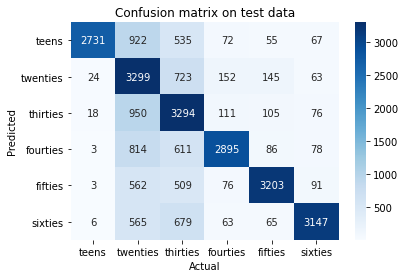

In [ ]:
#plot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

idx = ["teens","twenties","thirties","fourties","fifties","sixties"]
cm = pd.DataFrame(confusion_matrix(y_test,y_test_pred) , index = idx , columns = idx)
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = idx, yticklabels = idx)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()